In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import  ensemble
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from sklearn.multioutput import MultiOutputRegressor
import optuna

d:\Juan Carlos Morales\SpectralReconstructionAS7265x\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Preprocesamiento**

In [18]:
df = pd.read_csv('./SPD_310.txt', delimiter=',', header=None)

# Transpuesta del DataFrame
df_transpuesto = df.T
df_transpuesto.reset_index(drop=True, inplace=True)
df_transpuesto = df_transpuesto.iloc[:, :-10]  

wavelengths_input = np.array([310, 350, 410, 433, 460, 485, 510, 535, 560, 585, 610, 645, 680, 705, 730, 760, 810, 860, 900, 940])
wavelengths_output = df_transpuesto.iloc[0]

# Salidas del modelo
y_ori = df_transpuesto.iloc[1:]

#-----------------------------------------------
wavelengths_from_df = np.array(df_transpuesto.iloc[0]).astype(int)
df_transpuesto.columns = wavelengths_from_df
df_transpuesto = df_transpuesto.drop(df_transpuesto.index[0])

filtered_columns = [col for col in wavelengths_input if col in df_transpuesto.columns]

# Entradas del modelo
X_ori = df_transpuesto[filtered_columns]

In [24]:
df_transpuesto.shape

(10000, 141)

In [20]:
# Datos de train, test y valid
X_train, X_val, y_train, y_val = train_test_split(X_ori.to_numpy(), y_ori.to_numpy(), test_size=0.20, random_state=1)

In [21]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((8000, 4), (2000, 4), (8000, 141), (2000, 141))


**Model**

In [5]:
def plot_model(data):
    plt.figure(figsize=(8, 4))
    plt.plot(wavelengths_output, data)
    plt.grid(True)
    plt.xlabel('Wavelength')
    plt.ylabel('Reflectance')
    plt.show()
    

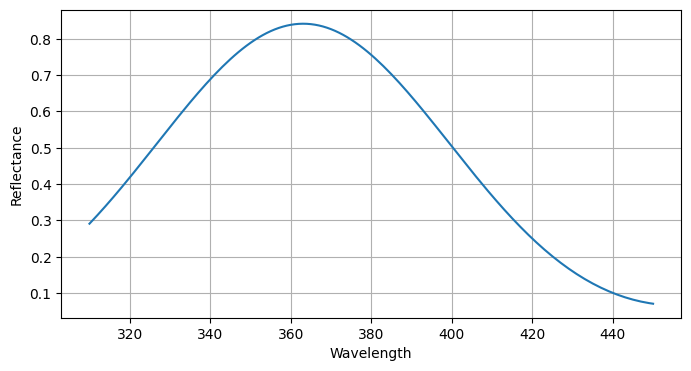

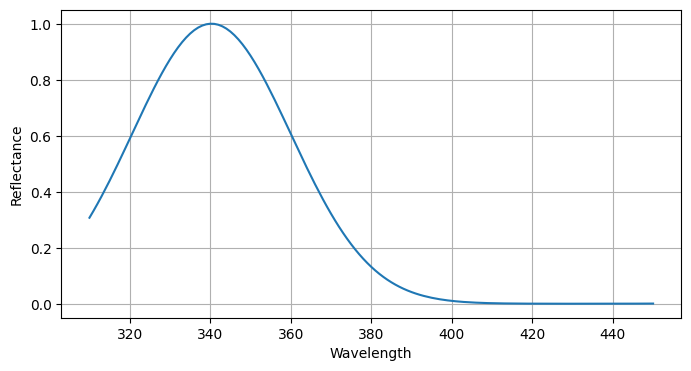

In [6]:
plot_model(df_transpuesto.iloc[25])
plot_model(df_transpuesto.iloc[12])

In [5]:

rf = RandomForestRegressor(n_estimators=100, random_state=42,max_depth=20, min_samples_split=2, min_samples_leaf=1)
rf.fit(X_train, y_train)    


RandomForestRegressor(max_depth=20, random_state=42)

In [21]:
def plot_predictions():
    plt.figure(figsize=(10, 6))
    plt.scatter(y_val, rf.predict(X_val), color='blue', label='Predicciones', alpha=0.5)
    #plt.scatter(y_test, y_test, color='red', label='Valores reales', alpha=0.5)
    plt.title('Valores reales vs. predicciones')
    plt.xlabel('Valores reales')
    plt.ylabel('Predicciones')
    plt.legend()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (4,)

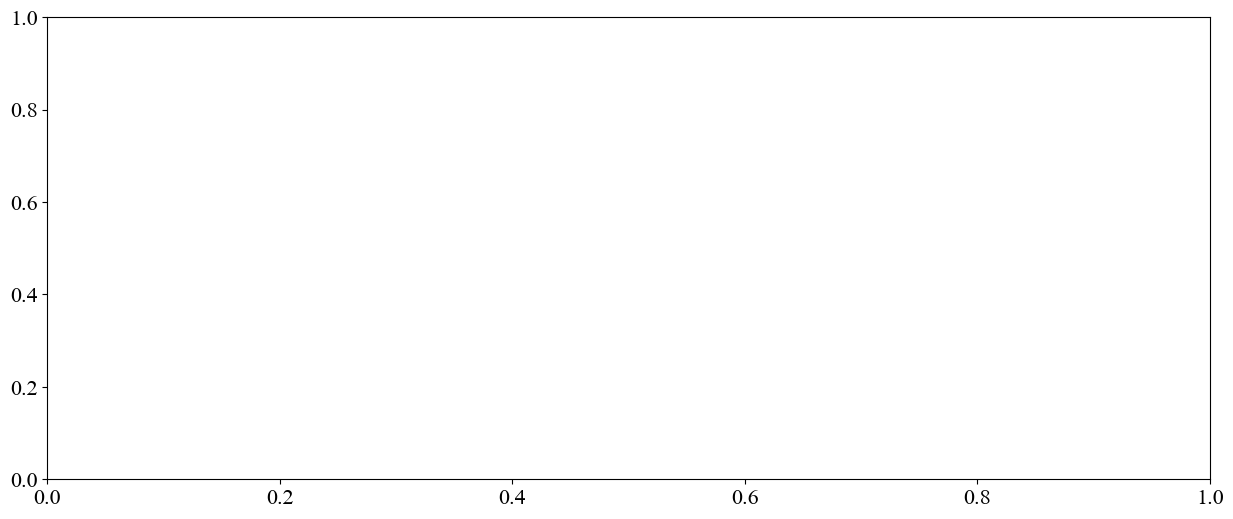

In [22]:
dato = 5
predictions = rf.predict(X_val)
entrada = X_val[dato]
real = y_val[dato,:]

# Crear una gráfica para comparar los valores reales con las predicciones
plt.figure(figsize=(15, 6))
plt.plot(wavelengths_input, entrada, label='Entrada', color='red', marker='o')
plt.plot(wavelengths_output, predictions[dato], label='Predicción', color='blue')
plt.plot(wavelengths_output, real, label='Real', color='green')
plt.title('Comparación de Entrada vs Predicción vs real')
plt.xlabel('Muestras')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [8]:
# Evaluar el modelo
predicciones = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, predicciones)
print(f'MSE para Crecimiento día con Random Forest: {mse_rf}')

MSE para Crecimiento día con Random Forest: 0.00873432012304498


**Optimización con Optuna**

In [10]:
import optuna

def objetive(trial):
    
    global history, X_test, y_test, X_train, y_train, model
    
    max_depth = trial.suggest_int('max_depth', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    
    model = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)
    history = model.fit(X_train, y_train)

    predicciones = model.predict(X_val)
    mse = mean_squared_error(y_val, predicciones)
    
    return mse

In [12]:
%%time
import optuna
history = []

# Creamos un estudio de optimización
study = optuna.create_study(direction='minimize')

# Ejecutamos el estudio de optimización
study.optimize(objetive, n_trials=100)                            
# Imprimimos los resultados de la optimización
print('Best trial:', study.best_trial.params)
print('Best loss:', study.best_value)

[I 2024-06-21 15:20:48,071] A new study created in memory with name: no-name-f6b57f39-039c-46a1-b6f8-88e761330a61
[I 2024-06-21 15:20:53,800] Trial 0 finished with value: 0.00024463772360343013 and parameters: {'max_depth': 12, 'n_estimators': 41, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.00024463772360343013.
[I 2024-06-21 15:20:54,620] Trial 1 finished with value: 0.02164669728090552 and parameters: {'max_depth': 2, 'n_estimators': 29, 'min_samples_split': 9, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.00024463772360343013.
[I 2024-06-21 15:21:01,293] Trial 2 finished with value: 0.0003688178335056335 and parameters: {'max_depth': 19, 'n_estimators': 54, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.00024463772360343013.
[I 2024-06-21 15:21:06,862] Trial 3 finished with value: 0.0020783980611671993 and parameters: {'max_depth': 6, 'n_estimators': 85, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is t

Best trial: {'max_depth': 17, 'n_estimators': 90, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best loss: 0.00018642393460417808
CPU times: total: 7min 20s
Wall time: 22min 21s


In [13]:

rf = RandomForestRegressor(n_estimators=90, random_state=42,max_depth=17, min_samples_split=2, min_samples_leaf=1)
rf.fit(X_train, y_train)    

RandomForestRegressor(max_depth=17, n_estimators=90, random_state=42)

In [14]:
# Evaluar el modelo
predicciones = rf.predict(X_val)
mse_rf = mean_squared_error(y_val, predicciones)
print(f'MSE para Crecimiento día con Random Forest: {mse_rf}')

MSE para Crecimiento día con Random Forest: 0.00019690002770343543


In [17]:
import matplotlib.ticker as tck

def plot_many_predictions(predict):
    datos = np.array([12, 145, 36, 48, 50, 120, 79, 89, 181])
    # Configurar la fuente a Times New Roman y el tamaño de la letra
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams["font.size"] = 16
    plt.rcParams["axes.titlesize"] = 16
    plt.rcParams["axes.labelsize"] = 18
    plt.rcParams["xtick.labelsize"] = 16
    plt.rcParams["ytick.labelsize"] = 16
    plt.rcParams["legend.fontsize"] = 12
    plt.rcParams["figure.titlesize"] = 20

    # Configurar los subplots
    fig, axs = plt.subplots(3, 3, figsize=(15, 10))

    # Lista de títulos para los subplots
    titles = ["IndrDlght, Flr", "LEDmix, Flr", "LEDmix, Tngstn", 
            "IndrDlght, Flr", "Flr, Tngstn", "LEDmix, IndrDlght",
            "pcLED_WW, IndrDlght", "pcLED_CW, IndrDlght", "LEDmix, IndrDlght"]

    # Colores personalizados
    colors = {
        'measured': 'black',
        'cnn2block': 'orange',
        'cnn1block': 'red',
        'mlp': 'blue'
    }

    # Iterar sobre los subplots y añadir los datos
    for i, ax in enumerate(axs.flat):
        idx = datos[i]  # Obtener el índice correspondiente de 'dato'
        ax.plot(wavelengths_output, predict[idx], color=colors['cnn2block'], marker='o', linestyle='none', label='CNN2Block')
        ax.plot(wavelengths_output, predict[idx], color=colors['mlp'], linestyle='-', label='MLP')
        ax.plot(wavelengths_output, y_val[idx, :], color=colors['cnn1block'], marker='o', linestyle='none', label='CNN1Block')
        ax.plot(wavelengths_input, X_val[idx], marker='o', color=colors['measured'], linestyle='-', label='Measured')  
        
        # Añadir título y leyenda
        ax.set_title(titles[i])

        ax.yaxis.set_minor_locator(tck.AutoMinorLocator())
        ax.xaxis.set_minor_locator(tck.AutoMinorLocator())

        # Añadir etiquetas solo en las posiciones deseadas
        if i // 3 == 2:  # última fila
            ax.set_xlabel('Wavelength (nm)')
        else:
            ax.set_xticklabels([])  # Eliminar etiquetas del eje X para filas que no sean la última

        if i % 3 == 0:  # primera columna
            ax.set_ylabel('Norm. irradiance')
        else:
            ax.set_yticklabels([])  # Eliminar etiquetas del eje Y para columnas que no sean la primera

    # Ajustar el layout
    plt.tight_layout()
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (20,) and (4,)

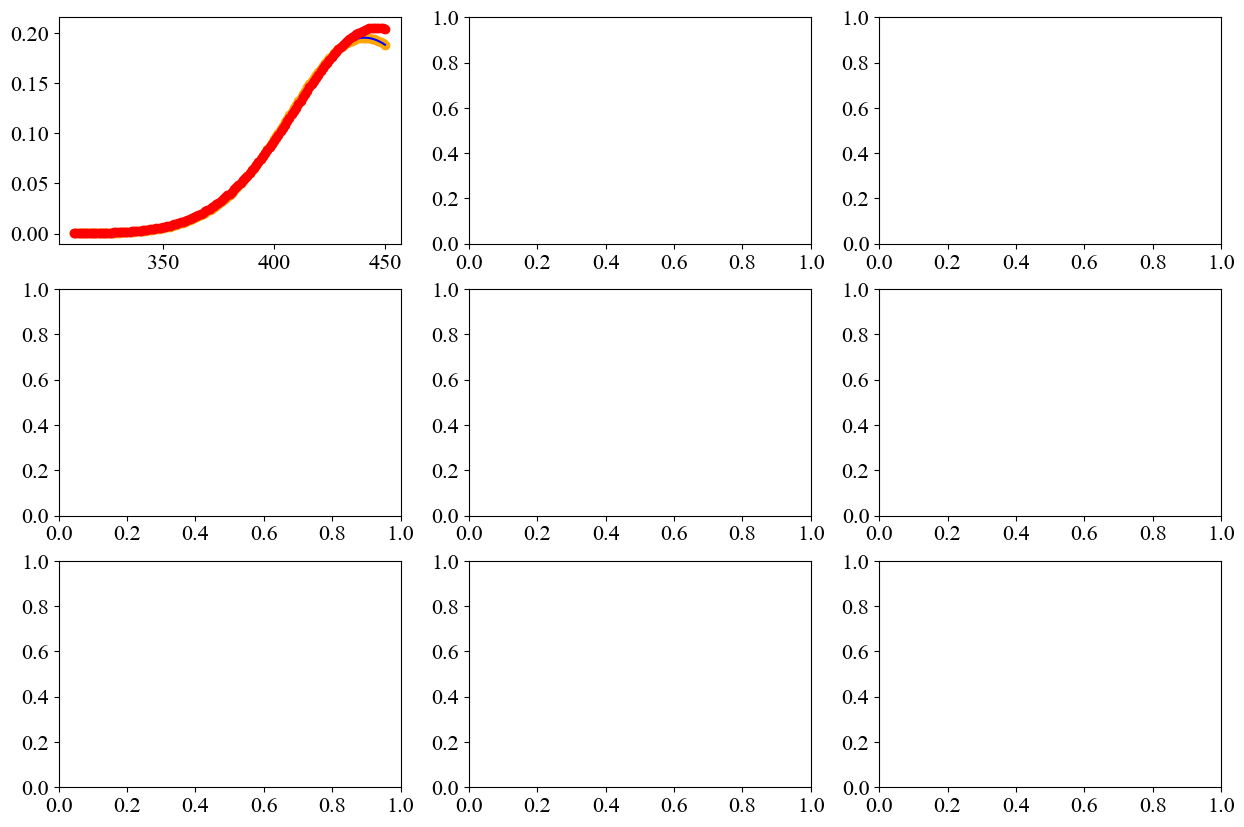

In [18]:
plot_many_predictions(predicciones)

**Gradient Boosting Regressors**

In [19]:
# Datos de train, test y valid
X_train, X_val, y_train, y_val = train_test_split(X_ori.to_numpy(), y_ori.to_numpy(), test_size=0.2, random_state=13)

In [48]:
params = {
    "n_estimators": 150,  # Comienza con un valor más pequeño
    "max_depth": 4,  # Mantén la profundidad de los árboles
    "min_samples_split": 5,  # Número mínimo de muestras para dividir un nodo
    "min_samples_leaf": 2,  # Número mínimo de muestras por hoja
    "learning_rate": 0.05,  # Ajusta la tasa de aprendizaje
    "loss": "squared_error",  # Función de pérdida
}

In [49]:
reg = ensemble.GradientBoostingRegressor(**params)
multi_target_reg = MultiOutputRegressor(reg)

In [ ]:
multi_target_reg.fit(X_train, y_train)

In [31]:
preds = multi_target_reg.predict(X_val)
mse = mean_squared_error(y_val, preds)
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 0.0304


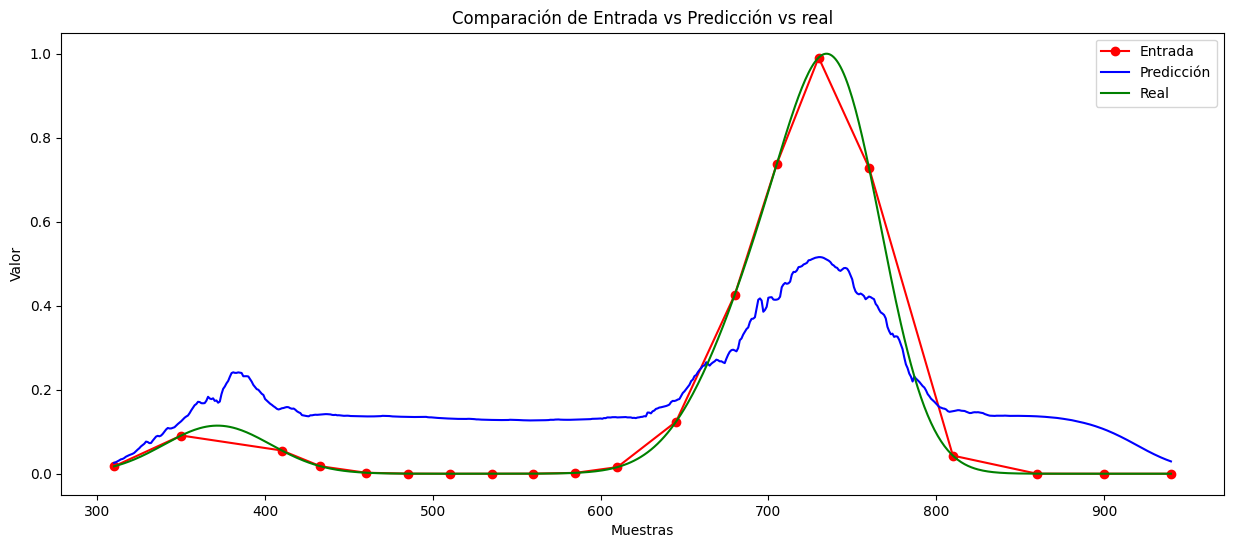

In [ ]:
dato = 128
predictions_gradient = rf.predict(X_val)
entrada = X_val[dato]
real = y_val[dato,:]

# Crear una gráfica para comparar los valores reales con las predicciones
plt.figure(figsize=(15, 6))
plt.plot(wavelengths_input, entrada, label='Entrada', color='red', marker='o')
plt.plot(wavelengths_output, preds[dato], label='Predicción', color='blue')
plt.plot(wavelengths_output, real, label='Real', color='green')
plt.title('Comparación de Entrada vs Predicción vs real')
plt.xlabel('Muestras')
plt.ylabel('Valor')
plt.legend()
plt.show()

In [19]:
def objective_gradient_boost(trial):
    
    global history, X_train, y_train, X_val, y_val
    
    # Hiperparámetros sugeridos por Optuna
    max_depth = trial.suggest_int('max_depth', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 10, 100)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)
    
    # Inicialización del modelo GradientBoostingRegressor
    model = ensemble.GradientBoostingRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        learning_rate=learning_rate
    )
    
    # Usar MultiOutputRegressor para el modelo
    multi_target_reg = MultiOutputRegressor(model)
    
    # Entrenamiento del modelo
    history = multi_target_reg.fit(X_train, y_train)

    # Predicciones y cálculo del error cuadrático medio
    predicciones = multi_target_reg.predict(X_val)
    mse = mean_squared_error(y_val, predicciones)
    
    return mse

In [20]:
%%time
history = []

study = optuna.create_study(direction='minimize')
# Ejecutamos el estudio de optimización
study.optimize(objective_gradient_boost, n_trials=10)                            
# Imprimimos los resultados de la optimización
print('Best trial:', study.best_trial.params)
print('Best loss:', study.best_value)

[I 2024-06-06 17:26:28,637] A new study created in memory with name: no-name-2aed7979-e825-4d78-bcbb-67c487f40d07
[I 2024-06-06 17:36:56,163] Trial 0 finished with value: 0.0034917664308621835 and parameters: {'max_depth': 1, 'n_estimators': 27, 'min_samples_split': 3, 'min_samples_leaf': 6, 'learning_rate': 0.2345995658007342}. Best is trial 0 with value: 0.0034917664308621835.
[I 2024-06-06 20:15:47,692] Trial 1 finished with value: 0.0027776675023657186 and parameters: {'max_depth': 7, 'n_estimators': 61, 'min_samples_split': 8, 'min_samples_leaf': 5, 'learning_rate': 0.028163960934100736}. Best is trial 1 with value: 0.0027776675023657186.
[I 2024-06-06 20:59:28,676] Trial 2 finished with value: 0.00022031134006815763 and parameters: {'max_depth': 8, 'n_estimators': 15, 'min_samples_split': 8, 'min_samples_leaf': 8, 'learning_rate': 0.2691638990872781}. Best is trial 2 with value: 0.00022031134006815763.
[I 2024-06-06 22:15:31,790] Trial 3 finished with value: 0.0002081762241066689

Best trial: {'max_depth': 7, 'n_estimators': 87, 'min_samples_split': 7, 'min_samples_leaf': 4, 'learning_rate': 0.10431501111587485}
Best loss: 0.00016171993951419921
CPU times: total: 10h 57min 11s
Wall time: 1d 2h 12min 12s


In [21]:
plot_many_predictions(predictions_gradient)

NameError: name 'predictions_gradient' is not defined